# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

44788


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5
import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook and chromosome size

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load distance map


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [9]:
# load main folder
# use the CW version instead for contact_th at 750nm
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\jie_CW_decode\postanalysis_v2CW_sorted'
postanalysis_folder_CW = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312'


In [10]:
class_2_cellInfoList_filename = os.path.join(postanalysis_folder, 'subclass_2_cellInfo.pkl')
class_2_cellInfoList = pickle.load(open(class_2_cellInfoList_filename, 'rb'))

if os.path.exists(class_2_cellInfoList_filename):
    print("Loading info.")
    class_2_info_Dict = np.load(class_2_cellInfoList_filename, allow_pickle=True)

Loading info.


In [11]:
#class_2_contact_filename = os.path.join(postanalysis_folder_CW, 'subclass_2_contactDict_750.pkl')
#print(class_2_contact_filename)
#if os.path.exists(class_2_contact_filename):
    #print("Loading contact")
    #class_2_contactDict = np.load(class_2_contact_filename, allow_pickle=True)
    
    
    
# subclass to median distance dict
class_2_median_filename = os.path.join(postanalysis_folder, 'subclass_2_medianDict.pkl')
if os.path.exists(class_2_median_filename):
    print("Loading median")
    class_2_medianDict = pickle.load(open(class_2_median_filename, 'rb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312\subclass_2_contactDict_750.pkl
Loading contact
Loading median


# 4. Plot dsitance map across selected celltypes

In [12]:
from ImageAnalysis3.structure_tools import distance

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=False)## load codebook


meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_44788\3428916836.py:80: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


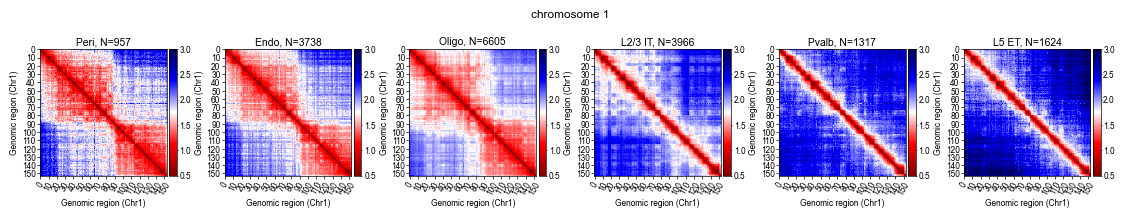

In [18]:
#%matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm
import ImageAnalysis3.structure_tools.distance as distance

sort_by_region = False
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=sort_by_region)


#plt.style.use('dark_background')
_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False


#chosen_chrom = _c1
#sel_class_list = ['L2/3 IT','L6 CT']
sel_cellgroups = ['Peri','Endo','Oligo','L2/3 IT','Pvalb','L5 ET',]
#sel_cellgroups = ['Vip','Pvalb', 'L2/3 IT', 'L5 ET',]
chosen_chrom = '1'

mtx_dict = {}

fig, axes = plt.subplots(1, len(sel_cellgroups), figsize=(_page_width/2.8*1*len(sel_cellgroups), 
                                                          _page_width/2.8*1.1), dpi=100, sharex=True, sharey=True)


for _idx, _class in enumerate(sel_cellgroups):
    
    summary_dict = class_2_medianDict[_class]

    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )
    
    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]
    
    mtx_dict[_class]=cis_mat_chr
    
    shared_color_limit= True
    if shared_color_limit:
        color_limits_class = [0.5, 3]
    else:
        pass
    
    ia.figure_tools.distmap.plot_distance_map(cis_mat_chr, color_limits=color_limits_class,
                                              ax=axes[_idx], 
                                            ticks=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              tick_labels=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                                #ticks=(chr_edges[1:] + chr_edges[:-1])/2,
                                              #tick_labels=chr_names,
                                              #color_norm='log',
                                              ax_label=f'Genomic region (Chr{chosen_chrom})', 
                                              cmap='seismic_r',
                                              font_size=_font_size-1.5)
    
    axes[_idx].grid(False)
    #axes[_idx].grid(True,color='g', linestyle='-', linewidth=0.5)
    axes[_idx].set_title(f'{_class}, N={len(class_2_cellInfoList[_class])}', fontsize=_font_size, pad=3)
    

for _ax in axes:
    #_ax.hlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    #_ax.vlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    _ax.xaxis.set_tick_params(which='both', labelbottom=True)
    _ax.yaxis.set_tick_params(which='both', labelleft=True)

fig.subplots_adjust(wspace=0.35, hspace=0.35, left=0.05, right=0.95, top=0.97, bottom=0.02)
fig.suptitle(f"chromosome {chosen_chrom}", fontsize=_font_size+1, y=0.97)
#fig.suptitle(f"{_class}, N={len(class_2_chr_zxys[_class])}", fontsize=10, y=0.97)
#fig.suptitle(f"{_class}, N={len(class_2_cellInfoList[_class])}", fontsize=10, y=0.97)
#fig.savefig(os.path.join(output_figure_folder, f"Cis-median_distmap_across_celltypes.png"))
plt.savefig(os.path.join(output_figure_folder, f'Cis-median_distmap_across_celltypes_chr{chosen_chrom}.pdf'), 
        transparent=True, dpi=300, bbox_inches='tight')

fig.show()

# 5. Normalize median map across celltype

In [19]:
# use ref_class L2/3 IT
ref_class = 'L2/3 IT'
print(f'Calculate normalization factor for chr{chosen_chrom}')


summary_dict = class_2_medianDict[ref_class]

_cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
        summary_dict, codebook_df, 
        sel_codebook=sel_codebook, 
        use_cis=True, sort_by_region=sort_by_region,
    )

_chr_indices = chr_2_indices[chosen_chrom]
cis_mat_chr = _cis_mat[:,_chr_indices]
cis_mat_chr = cis_mat_chr[_chr_indices,:]
ref_mat_median=np.nanmedian(cis_mat_chr)


# get normalization scale
norm_factor_dict = {}
for _idx, _class in enumerate(class_2_medianDict.keys()):
    
    summary_dict = class_2_medianDict[_class]

    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]
    _cis_mat_median = np.nanmedian(cis_mat_chr)
    norm_factor_dict[_class] = _cis_mat_median/ref_mat_median
    
norm_factor_dict.keys()

Calculate normalization factor for chr1


dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_44788\1725694232.py:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


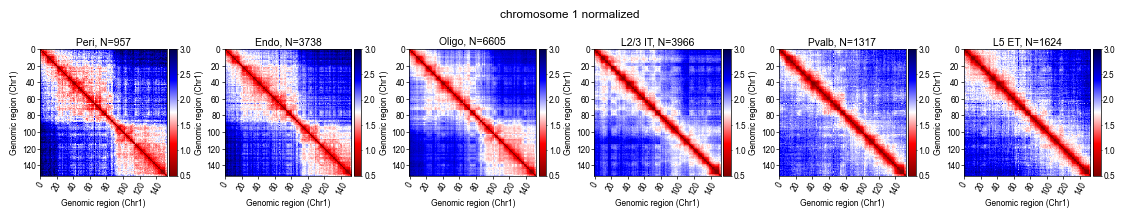

In [22]:
#%matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm
import ImageAnalysis3.structure_tools.distance as distance

sort_by_region = False
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=sort_by_region)


#plt.style.use('dark_background')
_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False



mtx_dict = {}

fig, axes = plt.subplots(1, len(sel_cellgroups), figsize=(_page_width/2.8*1*len(sel_cellgroups), 
                                                          _page_width/2.8*1.1), dpi=100, sharex=True, sharey=True)


for _idx, _class in enumerate(sel_cellgroups):
    
    summary_dict = class_2_medianDict[_class]

    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )
    
    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]
    
    cis_mat_chr = cis_mat_chr/norm_factor_dict[_class]
    
    mtx_dict[_class]=cis_mat_chr
    
    shared_color_limit= True
    if shared_color_limit:
        color_limits_class = [0.5, 3]
    else:
        pass
    
    ia.figure_tools.distmap.plot_distance_map(cis_mat_chr, color_limits=color_limits_class,
                                              ax=axes[_idx], 
                                            ticks=[i for i in np.arange(0,len(cis_mat_chr)) if i%20==0],
                                              tick_labels=[i for i in np.arange(0,len(cis_mat_chr)) if i%20==0],
                                                #ticks=(chr_edges[1:] + chr_edges[:-1])/2,
                                              #tick_labels=chr_names,
                                              #color_norm='log',
                                              ax_label=f'Genomic region (Chr{chosen_chrom})', 
                                              cmap='seismic_r',
                                              font_size=_font_size-1.5)
    
    axes[_idx].grid(False)
    #axes[_idx].grid(True,color='g', linestyle='-', linewidth=0.5)
    axes[_idx].set_title(f'{_class}, N={len(class_2_cellInfoList[_class])}', fontsize=_font_size, pad=3)
    

for _ax in axes:
    #_ax.hlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    #_ax.vlines(chr_edges-0.5, 0, len(_cis_mat), color='black', linewidth=0.2)
    _ax.xaxis.set_tick_params(which='both', labelbottom=True)
    _ax.yaxis.set_tick_params(which='both', labelleft=True)

fig.subplots_adjust(wspace=0.35, hspace=0.35, left=0.05, right=0.95, top=0.97, bottom=0.02)
fig.suptitle(f"chromosome {chosen_chrom} normalized", fontsize=_font_size+1, y=0.97)
#fig.suptitle(f"{_class}, N={len(class_2_chr_zxys[_class])}", fontsize=10, y=0.97)
#fig.suptitle(f"{_class}, N={len(class_2_cellInfoList[_class])}", fontsize=10, y=0.97)
#fig.savefig(os.path.join(output_figure_folder, f"Cis-median_distmap_across_celltypes.png"))
plt.savefig(os.path.join(output_figure_folder, f'Cis-median_distmap_across_celltypes_chr{chosen_chrom}_normalized.pdf'), 
        transparent=True, dpi=300, bbox_inches='tight')

fig.show()